In [66]:
import openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

In [67]:
# Get dataset by ID
dataset = openml.datasets.get_dataset(31)
# Convert to pandas dataframe
dataset = pd.DataFrame(dataset.get_data()[0])
dataset_encoded = pd.DataFrame()

dataset.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951.0,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096.0,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870.0,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [68]:
# create a new dataframe to store the encoded features
encoded_dataset = pd.DataFrame()

# Encode the target features using label encoding
targets = np.array(LabelEncoder().fit_transform(dataset['class'])).flatten()

# Encode categorical features into numerical values using one-hot encoding
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['checking_status'], prefix='checking_status')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['credit_history'], prefix='credit_history')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['savings_status'], prefix='savings_status')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['employment'], prefix='employment')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['personal_status'], prefix='personal_status')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['other_parties'], prefix='other_parties')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['property_magnitude'], prefix='property_magnitude')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['other_payment_plans'], prefix='other_payment_plans')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['housing'], prefix='housing')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['existing_credits'], prefix='existing_credits')], axis=1)
encoded_dataset = pd.concat([encoded_dataset, pd.get_dummies(dataset['job'], prefix='job')], axis=1)

# Encode binary features into 0 and 1
encoded_dataset['foreign_worker'] = pd.Series(np.where(dataset['foreign_worker'] == 'yes', 1, 0),dataset.index)
encoded_dataset['own_telephone'] = pd.Series(np.where(dataset['own_telephone'] == 'yes', 1, 0),dataset.index)

# copy numerical features from source dataset
encoded_dataset['credit_amount'] = dataset['credit_amount']
encoded_dataset['duration'] = dataset['duration']
encoded_dataset['installment_commitment'] = dataset['installment_commitment']
encoded_dataset['residence_since'] = dataset['residence_since']
encoded_dataset['age'] = dataset['age']
encoded_dataset['num_dependents'] = dataset['num_dependents']

encoded_dataset.dropna(inplace=True)

encoded_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 53 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   checking_status_<0                             1000 non-null   uint8  
 1   checking_status_0<=X<200                       1000 non-null   uint8  
 2   checking_status_>=200                          1000 non-null   uint8  
 3   checking_status_no checking                    1000 non-null   uint8  
 4   credit_history_no credits/all paid             1000 non-null   uint8  
 5   credit_history_all paid                        1000 non-null   uint8  
 6   credit_history_existing paid                   1000 non-null   uint8  
 7   credit_history_delayed previously              1000 non-null   uint8  
 8   credit_history_critical/other existing credit  1000 non-null   uint8  
 9   savings_status_<100                            1000 n

In [69]:
# Split the data into training and testing sets
data_train, data_test, target_train, target_test = train_test_split(encoded_dataset, targets, test_size=0.3)

clf = RandomForestClassifier(n_jobs=-1,oob_score=True)

clf.fit(data_train, target_train.flatten())

clf.score(data_test, target_test.flatten())

0.76

In [70]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100,150,200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(data_train, target_train)

# Print the best hyperparameters and their corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

clf.set_params(**grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Best score: 0.77


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, n_jobs=-1, oob_score=True)

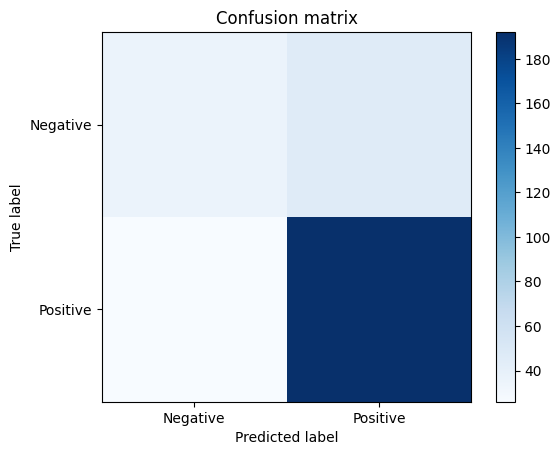

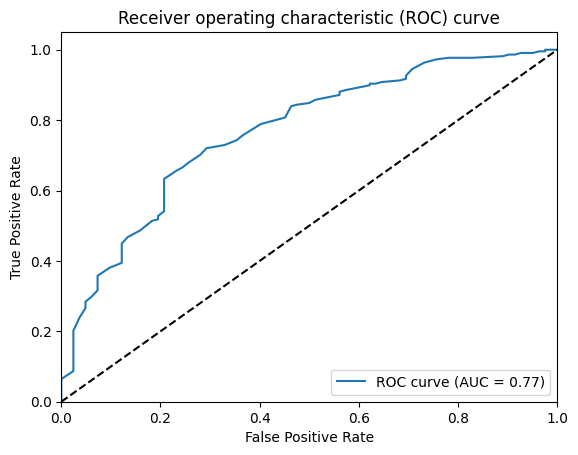

In [71]:
# Make predictions on the test set
target_predict = clf.predict(data_test)

# Calculate the confusion matrix
cm = confusion_matrix(target_test, target_predict)

# Visualize the confusion matrix using a heatmap
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Calculate the ROC curve and AUC score
target_predict_prob = clf.predict_proba(data_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_predict_prob)
auc_score = roc_auc_score(target_test, target_predict_prob)

# Visualize the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()